# Data Description
- Major League Baseball Data from the 1986 and 1987 seasons.
- There are 322 rows, with 59 rows of missing values. 263 left.
- There are 20 variables:
    - AtBat: Number of times at bat in 1986
    - Hits: Number of hits in 1986
    - HmRun: Number of home runs in 1986
    - Runs: Number of runs in 1986
    - RBI: Number of runs batted in in 1986
    - Walks: Number of walks in 1986
    - Years: Number of years in the major leagues
    - CAtBat: Number of times at bat during his career
    - CHits: Number of hits during his career
    - CHmRun: Number of home runs during his career
    - CRuns: Number of runs during his career
    - CRBI: Number of runs batted in during his career
    - CWalks: Number of walks during his career
    - League: A factor with levels A and N indicating player’s league at the end of 1986
    - Division: A factor with levels E and W indicating player’s division at the end of 1986
    - PutOuts: Number of put outs in 1986
    - Assists: Number of assists in 1986
    - Errors: Number of errors in 1986
    - Salary: 1987 annual salary on opening day in thousands of dollars
    - NewLeague: A factor with levels A and N indicating player’s league at the beginning of 1987

# Load Packages and Data

In [1]:
%%capture
pip install ISLP

In [1]:
%%capture
pip install l0bnb

In [3]:
%%capture
pip install --upgrade scikit-learn

In [2]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import \
     (ModelSpec as MS, Stepwise,
      sklearn_selected, sklearn_selection_path)
from l0bnb import fit_path
from functools import partial

In [3]:
Hitters = load_data('Hitters')
Hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [4]:
Hitters.describe().round(1)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
count,322.0,322.0,322.0,322.0,322.0,322.0,322.0,322.0,322.0,322.0,322.0,322.0,322.0,322.0,322.0,322.0,263.0
mean,380.9,101.0,10.8,50.9,48.0,38.7,7.4,2648.7,717.6,69.5,358.8,330.1,260.2,288.9,106.9,8.0,535.9
std,153.4,46.5,8.7,26.0,26.2,21.6,4.9,2324.2,654.5,86.3,334.1,333.2,267.1,280.7,136.9,6.4,451.1
min,16.0,1.0,0.0,0.0,0.0,0.0,1.0,19.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,67.5
25%,255.2,64.0,4.0,30.2,28.0,22.0,4.0,816.8,209.0,14.0,100.2,88.8,67.2,109.2,7.0,3.0,190.0
50%,379.5,96.0,8.0,48.0,44.0,35.0,6.0,1928.0,508.0,37.5,247.0,220.5,170.5,212.0,39.5,6.0,425.0
75%,512.0,137.0,16.0,69.0,64.8,53.0,11.0,3924.2,1059.2,90.0,526.2,426.2,339.2,325.0,166.0,11.0,750.0
max,687.0,238.0,40.0,130.0,121.0,105.0,24.0,14053.0,4256.0,548.0,2165.0,1659.0,1566.0,1378.0,492.0,32.0,2460.0


In [4]:
np.isnan(Hitters['Salary']).sum()

59

In [5]:
Hitters = Hitters.dropna()
Hitters.shape

(263, 20)

# Subset Selection Methods
## Forward Selection
- We predict a baseball player’s `Salary` on the basis of various statistics associated with performance in the previous year.
- We use forward selection to choose the best model based on $C_p$. Since $C_p$ isn't a built-in `sklearn` metric, we create a custom function to compute it. To align with `sklearn`'s score maximization, our function returns the negative $C_p$.

In [6]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

- We need the residual variance ($\sigma^2$) to score our model. We'll calculate it from the largest model's MSE.

In [7]:
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)
sigma2 = sm.OLS(Y,X).fit().scale

- The `sklearn_selected()` from `ISLP.models` function needs a scorer with only the last 3 arguments from `nCp()`. We'll use `partial()` to fix the first argument with our $\sigma^2$ estimate.

In [8]:
neg_Cp = partial(nCp, sigma2)

- We can now use `neg_Cp()` as a scorer for model selection.
- We define the search strategy with `Stepwise()` from `ISLP.models`. `Stepwise.first_peak()` continues until no score improvement is found, while `Stepwise.fixed_steps()` runs a set number of steps.

In [9]:
strategy = Stepwise.first_peak(design, direction='forward', max_terms=len(design.terms))

- We fit a linear regression model with `Salary` as the outcome using forward selection with `sklearn_selected()` from `ISLP.models`. This function uses a `statsmodels` model and a search strategy, defaulting to MSE for scoring, which selects all 19 variables.

In [10]:
hitters_MSE = sklearn_selected(sm.OLS, strategy) # using MSE for scoring
hitters_MSE.fit(Hitters, Y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

- Using `neg_Cp` yields a smaller model with only 10 selected variables.

In [11]:
hitters_Cp = sklearn_selected(sm.OLS, strategy, scoring=neg_Cp)
hitters_Cp.fit(Hitters, Y)
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

## Choosing Among Models Using the Validation Set Approach and Cross-Validation
 
- Instead of using $C_p$, we can use cross-validation for model selection in forward selection. The `sklearn_selection_path()` estimator from `ISLP.models` stores the models found, and `cross_val_predict()` computes cross-validated predictions for evaluating MSE along the path.
- We define a strategy that follows the full forward selection path. Using the default settings of `sklearn_selection_path()`, we select the model at each step based on the greatest reduction in RSS.

In [12]:
strategy = Stepwise.fixed_steps(design, len(design.terms), direction='forward')
full_path = sklearn_selection_path(sm.OLS, strategy)

- We fit the full forward-selection path on the `Hitters` data and calculate the fitted values.

In [13]:
full_path.fit(Hitters, Y)
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape

(263, 20)

- We obtain 20 arrays of fitted values from 20 models, including the null model’s mean, to evaluate in-sample MSE. As expected, MSE improves with each step, so we need validation or cross-validation to select the number of steps.
- The y-axis is fixed set from 50,000 to 250,000 for comparison with cross-validation MSE and other methods like ridge regression and lasso.

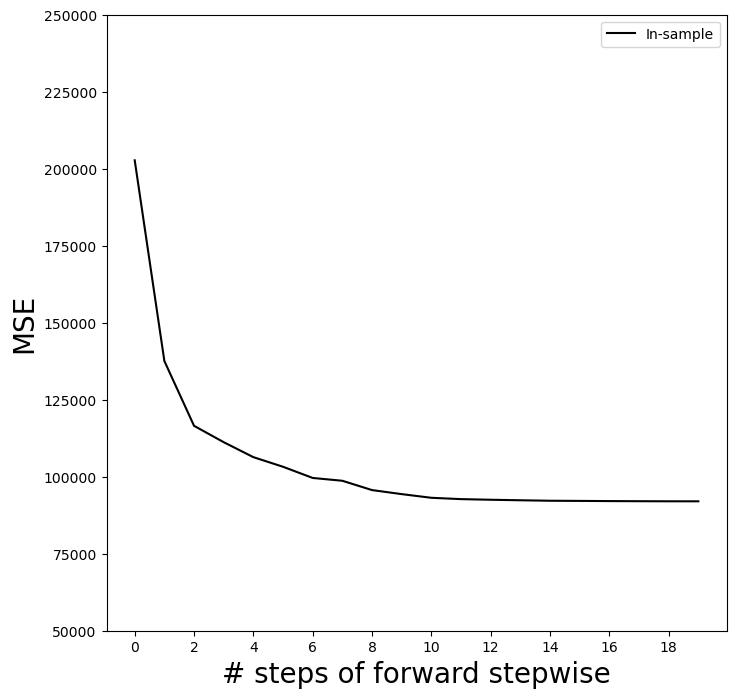

In [14]:
mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0) # Y[:,None] is column vector
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
        insample_mse,
        'k', # color black
        label='In-sample')
ax.set_ylabel('MSE', fontsize=20)
ax.set_xlabel('# steps of forward stepwise', fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2]); ax.legend()
ax.set_ylim([50000,250000]);

- We’re ready to use cross-validation to estimate test error along the model path. It’s important to use *only the training data* for all model-fitting steps, including variable selection. This means that in each training fold, we select the best model size based only on that fold’s training data. Using the full dataset for selection would give inaccurate test error estimates.
- We’ll now perform 5-fold cross-validation to compute cross-validated predictions.

In [15]:
K = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path, Hitters, Y, cv=kfold)
Yhat_cv.shape

(263, 20)

- `skm.cross_val_predict()` creates a prediction matrix `Yhat_cv` that has the same shape as `Yhat_in`. The key difference is that each prediction in `Yhat_cv` is made by a model trained on a fold that *excludes* the sample for that specific row.
- For each model along the path, we compute the MSE in each cross-validation fold. We then average these to get the mean MSE and use them to estimate the standard error. This error estimate is rough because the training sets overlap, so the errors aren’t fully independent.
- To do this, we need the test indices for each split, which we get using the `split()` method of `kfold`. Since we set a fixed random state, we’ll get consistent splits whenever we use arrays with the same number of rows as `Y`.

In [16]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx,None])**2
    cv_mse.append(errors.mean(0)) # column means
cv_mse = np.array(cv_mse).T
cv_mse.shape

(20, 5)

- We now add the cross-validation error estimates to our MSE plot, showing the mean error across the five folds and the estimated standard error.

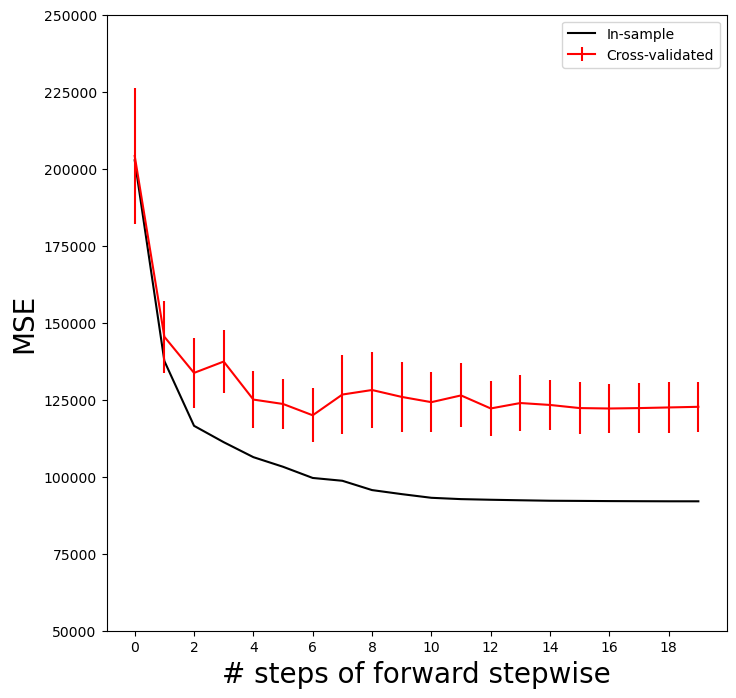

In [17]:
ax.errorbar(np.arange(n_steps), # n_steps=20
            cv_mse.mean(1),
            cv_mse.std(1) / np.sqrt(K),
            label='Cross-validated',
            c='r') # color red
ax.set_ylim([50000,250000]); ax.legend(); mse_fig

- To repeat this using the validation set approach, we just change the `cv` argument to a single random split of the data into training and test sets, with a test size of 20%, similar to each test set in 5-fold cross-validation. We use `skm.ShuffleSplit()` for this.

In [18]:
validation = skm.ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_idx, test_idx = list(validation.split(Y))[0]
full_path.fit(Hitters.iloc[train_idx], Y[train_idx])
Yhat_val = full_path.predict(Hitters.iloc[test_idx])
errors = (Yhat_val - Y[test_idx,None])**2
validation_mse = errors.mean(0)

- Like in the in-sample MSE case, the validation set approach does not provide standard errors.

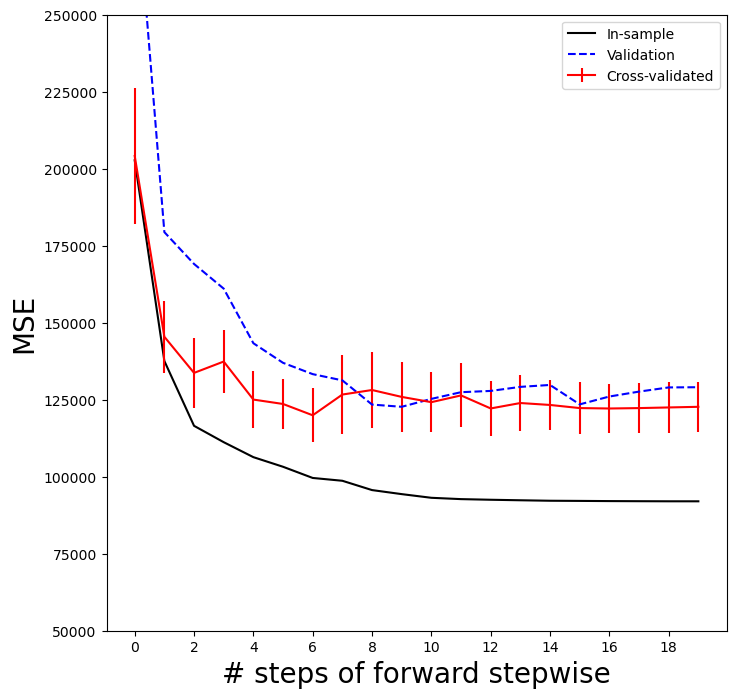

In [19]:
ax.plot(np.arange(n_steps), 
        validation_mse,
        'b--', # color blue, broken line
        label='Validation')
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([50000,250000]); ax.legend(); mse_fig

## Best Subset Selection
- Forward stepwise selection is a *greedy* method that adds one variable at a time to the model. Now, we’ll apply best subset selection to the `Hitters` data, where the best predictor set is chosen for each subset size.
- We’ll use the `l0bnb` package for best subset selection. Instead of fixing the subset size, this package treats subset size as a penalty, creating a path of solutions. This difference affects how we handle cross-validation.

In [20]:
D = design.fit_transform(Hitters)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

- We exclude the first column (intercept) since `l0bnb` fits it separately. We then use `fit_path()` to find a solution path.

In [21]:
path = fit_path(X, Y, max_nonzeros=X.shape[1])

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19


- The `fit_path()` function returns a list with the fitted coefficients (`B`), the intercept (`B0`), and other details specific to the path algorithm, which we won’t cover here.

In [22]:
path[3]

{'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.67775265, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 'B0': -38.98216739555505,
 'lambda_0': 0.011416248027450207,
 'M': 0.5829861733382011,
 'Time_exceeded': False}

- At the fourth step, `'B'` has two nonzero coefficients with a penalty `lambda_0` of $0.114$.
- Predictions can be made on a validation set based on `lambda_0` or via cross-validation.

# Ridge Regression
- We start with `X` (without an intercept)
- We use the function `skl.ElasticNet()` from `sklearn.linear_model` to fit both  ridge and the lasso.
- To fit a path of ridge regression models, use `skl.ElasticNet.path()`. It handles ridge, lasso, and hybrid models; ridge regression requires `l1_ratio=0`.
- Standardizing `X` columns is important if variables use different units. `skl.ElasticNet()` doesn’t normalize, so do it manually.
- After standardizing, unstandardize coefficients to get them on the original scale.
- The parameter $\lambda$ is called `alphas` in `sklearn`. For consistency, we'll refer to it as `lambdas`.

In [23]:
# Standardization
Xs = X - X.mean(0)[None,:] # X.mean(0)[None,:] is row vector
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]

In [24]:
import warnings
# Ignore UserWarning
warnings.filterwarnings('ignore', category=UserWarning)

In [25]:
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(Xs, Y, l1_ratio=0., alphas=lambdas)
soln_array

(array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
        8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
        3.45506012e+04, 2.73807606e+04, 2.16987845e+04, 1.71959156e+04,
        1.36274691e+04, 1.07995362e+04, 8.55844774e+03, 6.78242347e+03,
        5.37495461e+03, 4.25955961e+03, 3.37562814e+03, 2.67512757e+03,
        2.11999285e+03, 1.68005808e+03, 1.33141730e+03, 1.05512544e+03,
        8.36168866e+02, 6.62649526e+02, 5.25138417e+02, 4.16163215e+02,
        3.29802231e+02, 2.61362628e+02, 2.07125413e+02, 1.64143347e+02,
        1.30080796e+02, 1.03086806e+02, 8.16945308e+01, 6.47415185e+01,
        5.13065463e+01, 4.06595605e+01, 3.22220063e+01, 2.55353890e+01,
        2.02363591e+01, 1.60369685e+01, 1.27090233e+01, 1.00716836e+01,
        7.98163700e+00, 6.32531083e+00, 5.01270066e+00, 3.97247954e+00,
        3.14812210e+00, 2.49483293e+00, 1.97711243e+00, 1.56682779e+00,
        1.24168423e+00, 9.84013516e-01, 7.79813883e-01, 6.179891

In [26]:
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(Xs, Y, l1_ratio=0., alphas=lambdas)[1]
soln_array.shape

(19, 100)

In [27]:
soln_array

array([[ 8.00310363e-04,  1.00986867e-03,  1.27429625e-03, ...,
        -2.90923382e+02, -2.90958537e+02, -2.90986528e+02],
       [ 8.89318672e-04,  1.12218451e-03,  1.41602291e-03, ...,
         3.37260446e+02,  3.37377455e+02,  3.37470648e+02],
       [ 6.95410715e-04,  8.77500619e-04,  1.10726717e-03, ...,
         3.75180641e+01,  3.75871222e+01,  3.76420770e+01],
       ...,
       [ 5.15666738e-05,  6.50694021e-05,  8.21076995e-05, ...,
         5.36633570e+01,  5.36777586e+01,  5.36891521e+01],
       [-1.09496252e-05, -1.38170424e-05, -1.74354208e-05, ...,
        -2.21910710e+01, -2.21848930e+01, -2.21799639e+01],
       [-5.74274914e-06, -7.24531429e-06, -9.14061794e-06, ...,
        -1.23832054e+01, -1.23761905e+01, -1.23705867e+01]])

- We extract the coefficient array for solutions along the regularization path. `skl.ElasticNet.path` automatically selects a range of $\lambda$ values, except when `l1_ratio=0` for ridge regression, since the smallest $\lambda$ for zero coefficients is technically $\infty$. We implement a custom range from $\lambda=10^{8}$ to $\lambda=10^{-2}$, scaled by the standard deviation of $y$, covering models from just an intercept to a least squares fit.
- Each $\lambda$ value corresponds to a vector of ridge coefficients, accessible by columns in `soln_array`. This matrix has 19 rows (one per predictor) and 100 columns (one per $\lambda$ value). We transpose it into a data frame for easier viewing and plotting.

In [28]:
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
negative log(lambda),,,,,,,,,,,,,,,,,,,
-12.310855,0.000800,0.000889,0.000695,0.000851,0.000911,0.000900,0.000812,0.001067,0.001113,0.001064,0.001141,0.001149,0.000993,-0.000029,-0.000390,0.000609,0.000052,-0.000011,-0.000006
-12.078271,0.001010,0.001122,0.000878,0.001074,0.001150,0.001135,0.001025,0.001346,0.001404,0.001343,0.001439,0.001450,0.001253,-0.000037,-0.000492,0.000769,0.000065,-0.000014,-0.000007
-11.845686,0.001274,0.001416,0.001107,0.001355,0.001451,0.001433,0.001293,0.001698,0.001772,0.001694,0.001816,0.001830,0.001581,-0.000046,-0.000621,0.000970,0.000082,-0.000017,-0.000009
-11.613102,0.001608,0.001787,0.001397,0.001710,0.001831,0.001808,0.001632,0.002143,0.002236,0.002138,0.002292,0.002309,0.001995,-0.000058,-0.000784,0.001224,0.000104,-0.000022,-0.000012
-11.380518,0.002029,0.002255,0.001763,0.002158,0.002310,0.002281,0.002059,0.002704,0.002821,0.002698,0.002892,0.002914,0.002517,-0.000073,-0.000990,0.001544,0.000131,-0.000028,-0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.784658,-290.823989,336.929968,37.322686,-59.748520,-26.507086,134.855915,-17.216195,-387.775826,89.573601,-12.273926,476.079273,257.271255,-213.124780,31.258215,-58.457857,78.761266,53.622113,-22.208456,-12.402891
10.017243,-290.879272,337.113713,37.431373,-59.916820,-26.606957,134.900549,-17.108041,-388.458404,89.000707,-12.661459,477.031349,257.966790,-213.280891,31.256434,-58.448850,78.761240,53.645147,-22.198802,-12.391969
10.249827,-290.923382,337.260446,37.518064,-60.051166,-26.686604,134.936136,-17.022194,-388.997470,88.537380,-12.971603,477.791860,258.523025,-213.405740,31.254958,-58.441682,78.761230,53.663357,-22.191071,-12.383205


- We set `legend` to `False` in the plot method, then add the legend later using `ax.legend()` to control its position.

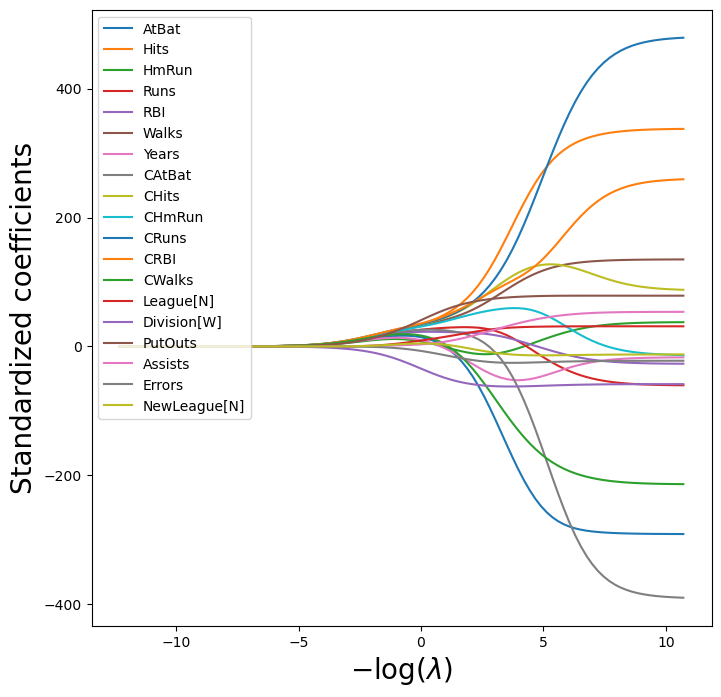

In [29]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left');

- We expect the coefficient estimates to be smaller in $\ell_2$ norm with a large $\lambda$ than with a small one (the $\ell_2$ norm is the square root of the sum of squared coefficients).
- Here, we show the coefficients at the 40th step, where $\lambda$ is 25.535.

In [30]:
beta_hat = soln_path.loc[soln_path.index[39]]
lambdas[39], beta_hat

(25.53538897200662,
 AtBat           5.433750
 Hits            6.223582
 HmRun           4.585498
 Runs            5.880855
 RBI             6.195921
 Walks           6.277975
 Years           5.299767
 CAtBat          7.147501
 CHits           7.539495
 CHmRun          7.182344
 CRuns           7.728649
 CRBI            7.790702
 CWalks          6.592901
 League[N]       0.042445
 Division[W]    -3.107159
 PutOuts         4.605263
 Assists         0.378371
 Errors         -0.135196
 NewLeague[N]    0.150323
 Name: -3.240065292879872, dtype: float64)

Let’s compute the $\ell_2$ norm of the standardized coefficients.

In [31]:
lambdas[39], np.linalg.norm(beta_hat)

(25.53538897200662, 24.170617201443775)

- In contrast, here’s the $\ell_2$ norm when $\lambda$ is 0.244.
- Notice the significantly larger $\ell_2$ norm for the coefficients with this smaller $\lambda$.

In [32]:
beta_hat = soln_path.loc[soln_path.index[59]]
lambdas[59], np.linalg.norm(beta_hat)

(0.24374766133488554, 160.42371017725873)

- We normalized `X` first and fitted the ridge model using `Xs`.
- The `Pipeline()` object in `sklearn` clearly separates feature normalization from fitting the ridge model.

In [33]:
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True,  with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.24374766133488554, l1_ratio=0))])

- `skl.ElasticNet` fits only for one lambda, whereas `skl.ElasticNet.path` fits for a vector of lambdas.
- We show that it gives the same $\ell_2$ norm as in our previous fit on the standardized data.

In [34]:
np.linalg.norm(ridge.coef_)

160.42371017725895

- Notice that the `pipe.fit(X, Y)` operation updated the `ridge` object, adding attributes like `coef_` that weren’t there before.

## Estimating Test Error of Ridge Regression
- Choosing an *a priori* value of $\lambda$ for ridge regression is challenging. Instead, we'll use validation or cross-validation to select the tuning parameter. The `Pipeline()` approach can be applied in `skm.cross_validate()` for either validation or $k$-fold cross-validation.
- We set a fixed random state for the splitter to ensure reproducible results.

In [35]:
validation = skm.ShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
ridge.alpha = 0.01
results = skm.cross_validate(ridge, X, Y, scoring='neg_mean_squared_error',
                             cv=validation)
-results['test_score']

array([134214.00419204])

- The test MSE is 1.342e+05. If we had only fit a model with an intercept, we'd predict each test observation using the training mean. A ridge regression model with a very large $\lambda$ (like $10^{10}$) would yield the same result.

In [36]:
ridge.alpha = 1e10
results = skm.cross_validate(ridge, X, Y, scoring='neg_mean_squared_error',
                             cv=validation)
-results['test_score']

array([231788.32155285])

- Choosing $\lambda = 0.01$ is arbitrary, so we’ll use cross-validation or a validation set to select the best $\lambda$. The `GridSearchCV()` object allows for an exhaustive grid search to find this parameter.
- We’ll start by using the validation set method to choose $\lambda$.

In [37]:
param_grid = {'ridge__alpha': lambdas}
grid = skm.GridSearchCV(pipe, param_grid, cv=validation,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.005899006046740856, l1_ratio=0))])

Alternatively, we can use 5-fold cross-validation.

In [38]:
grid = skm.GridSearchCV(pipe, param_grid, cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.01185247763144249, l1_ratio=0))])

- We now plot the cross-validated MSE as a function of $-\log(\lambda)$, which has shrinkage decreasing from left
to right.

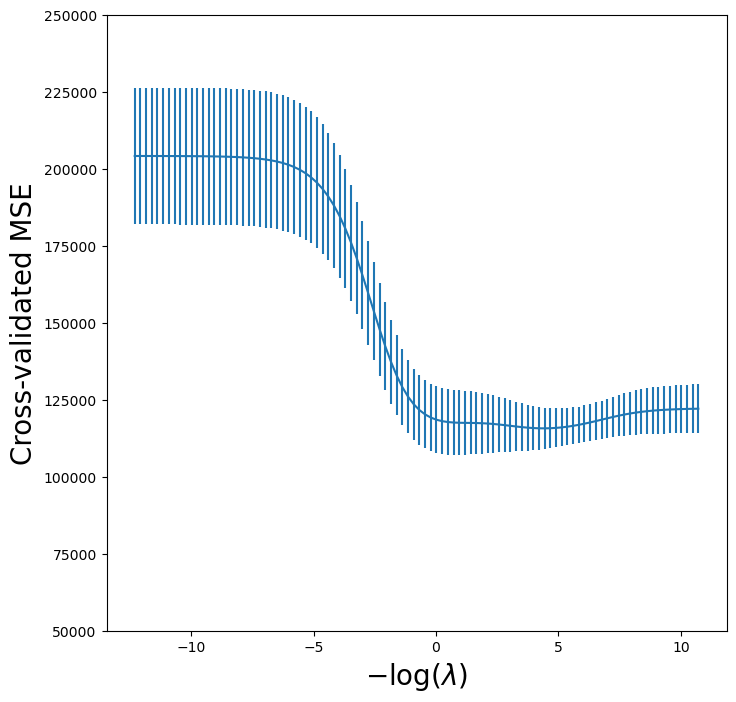

In [39]:
ridge_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas), -grid.cv_results_['mean_test_score'],
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

- You can cross-validate different metrics to choose a parameter. The default metric for `sklearn.ElasticNet()` is test $R^2$. Let's compare $R^2$ and MSE for cross-validation.

In [40]:
grid_r2 = skm.GridSearchCV(pipe, param_grid, cv=kfold)
grid_r2.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge',
                                        ElasticNet(alpha=10000000000.0,
                                                   l1_ratio=0))]),
             param_grid={'ridge__alpha': array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606...
       4.67486141e-03, 3.70474772e-03, 2.93594921e-03, 2.32668954e-03,
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05])})

Finally, let’s plot the results for cross-validated $R^2$.

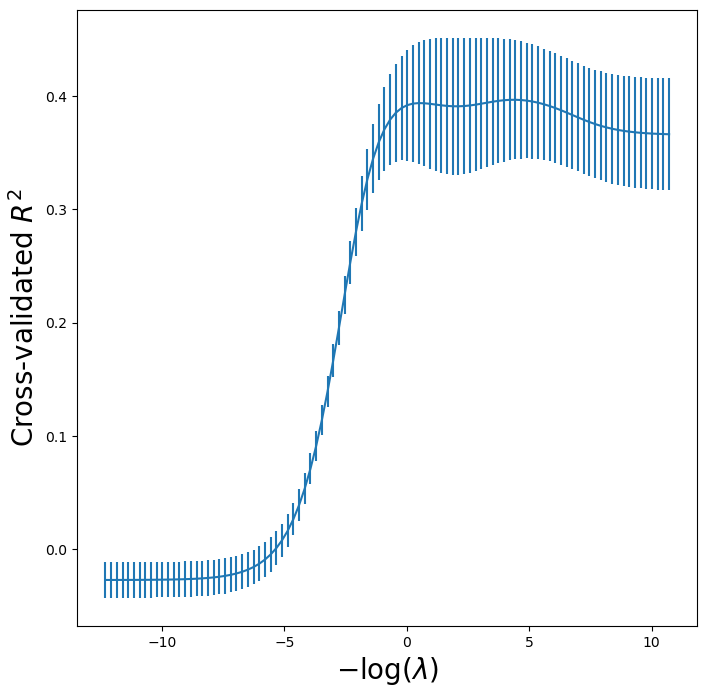

In [41]:
r2_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            grid_r2.cv_results_['mean_test_score'],
            yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated $R^2$', fontsize=20);

## Fast Cross-Validation for Solution Paths
- Ridge, lasso, and elastic net can be efficiently fitted along a series of $\lambda$ values, forming a *solution path* or *regularization path*.
- Specialized code helps fit these paths and select a suitable $\lambda$ using cross-validation. Results might differ slightly from our `grid` because standardization in `grid` occurs in each fold, while in `pipeCV`, it's done once. Despite this, the results are similar as normalization remains stable across folds.

In [42]:
ridgeCV = skl.ElasticNetCV(alphas=lambdas, l1_ratio=0, cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])
pipeCV.fit(X, Y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606e+04, 2.16987845e+04, 1.71959156e+04,
       1.36274691e+04, 1.07995362e+04, 8.55844774e+03, 6.78242347e+03,
       5.37495461e+03, 4.25955961e+03,...
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

Let’s produce a plot again of the cross-validation error to see that
it is similar to using `skm.GridSearchCV`.

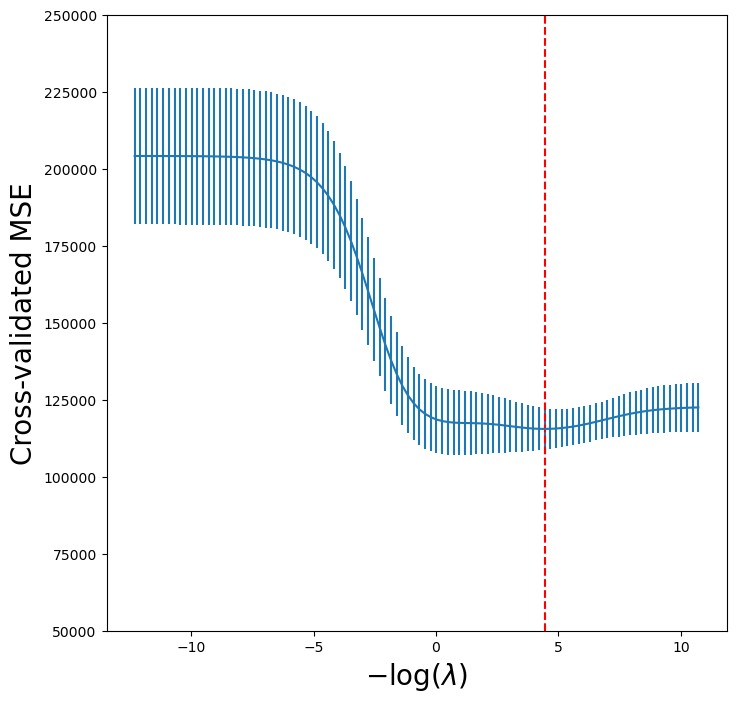

In [43]:
tuned_ridge = pipeCV.named_steps['ridge']
ridgeCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            tuned_ridge.mse_path_.mean(1),
            yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='r', ls='--')
ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

- We see that the value of $\lambda$ that results in the
smallest cross-validation error is 1.19e-02, available
as the value `tuned_ridge.alpha_`. What is the test MSE
associated with this value of $\lambda$?

In [44]:
np.min(tuned_ridge.mse_path_.mean(1))

115526.70630987808

- This represents a further improvement over the test MSE that we got
using $\lambda=4$.  Finally, `tuned_ridge.coef_`
has the coefficients fit on the entire data set
at this value of  $\lambda$.

In [45]:
tuned_ridge.coef_

array([-222.80877051,  238.77246614,    3.21103754,   -2.93050845,
          3.64888723,  108.90953869,  -50.81896152, -105.15731984,
        122.00714801,   57.1859509 ,  210.35170348,  118.05683748,
       -150.21959435,   30.36634231,  -61.62459095,   77.73832472,
         40.07350744,  -25.02151514,  -13.68429544])

- As expected, none of the coefficients are zero—ridge regression does
not perform variable selection!

## Evaluating Test Error of Cross-Validated Ridge
- Choosing $\lambda$ with cross-validation gives us a single regression estimator, like fitting a linear model. However, since cross-validation uses all the data to choose $\lambda$, we can't estimate test error directly. To solve this, we split the data into training and test sets. We tune ridge regression on the training set using cross-validation, then evaluate it on the test set. This approach is like nested cross-validation within a validation set. We use 75% for training and 25% for testing, with ridge regression tuned via 5-fold cross-validation. Here's how to implement it:

In [46]:
outer_valid = skm.ShuffleSplit(n_splits=1, 
                               test_size=0.25,
                               random_state=1)
inner_cv = skm.KFold(n_splits=5,
                     shuffle=True,
                     random_state=2)
ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,
                           cv=inner_cv)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)]);

In [47]:
results = skm.cross_validate(pipeCV, X, Y, cv=outer_valid,
                             scoring='neg_mean_squared_error')

In [48]:
-results['test_score']

array([132393.84003227])

# The Lasso
- We found that with a good choice of $\lambda$, ridge regression can outperform least squares and the null model on the `Hitters` dataset. Now, we’ll explore whether the lasso can provide a more accurate or interpretable model than ridge regression. To fit a lasso model, we’ll use the `ElasticNetCV()` function with `l1_ratio=1`, while following the same steps as for the ridge model.

In [49]:
lassoCV = skl.ElasticNetCV(n_alphas=100, 
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

3.1472370031649866

In [50]:
lambdas, soln_array = skl.Lasso.path(Xs, 
                                    Y,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

We can see from the coefficient plot of the standardized coefficients that depending on the choice of
tuning parameter, some of the coefficients will be exactly equal to
zero.

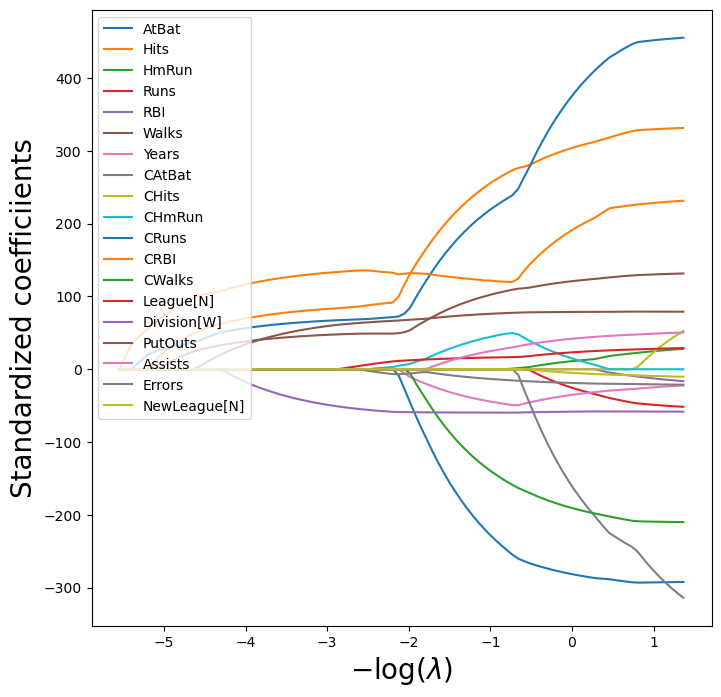

In [51]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

The smallest cross-validated error is lower than the test set MSE of the null model
and of least squares, and very similar to the test MSE of 115526.71 of ridge
regression (page~\pageref{page:MSECVRidge}) with $\lambda$ chosen by cross-validation.

In [52]:
np.min(tuned_lasso.mse_path_.mean(1))

114690.73118253701

Let’s again produce a plot of the cross-validation error.


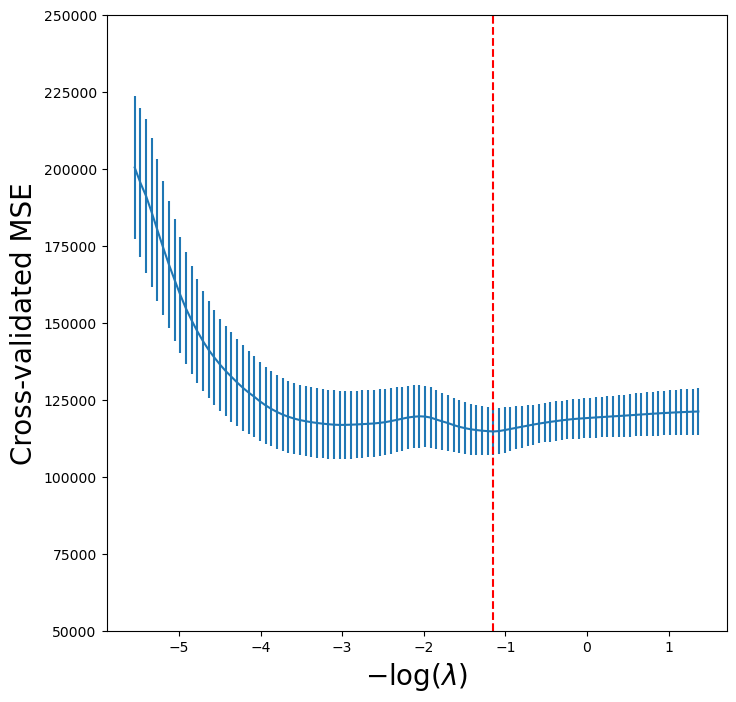

In [53]:
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='r', ls='--')
ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

- The lasso's advantage over ridge regression is its sparse coefficients. Here, 6 of the 19 coefficients are exactly zero, so the lasso model with cross-validated $\lambda$ includes only 13 variables.

In [54]:
tuned_lasso.coef_

array([-210.01008773,  243.4550306 ,    0.        ,    0.        ,
          0.        ,   97.69397357,  -41.52283116,   -0.        ,
          0.        ,   39.62298193,  205.75273856,  124.55456561,
       -126.29986768,   15.70262427,  -59.50157967,   75.24590036,
         21.62698014,  -12.04423675,   -0.        ])

- Like ridge regression, evaluate cross-validated lasso's test error by splitting into test and training sets, then running cross-validation on the training set. This is left as an exercise.

# Principal Components Regression

- Perform Principal Components Regression (PCR) using `PCA()` from `sklearn.decomposition` on the `Hitters` data to predict `Salary`, ensuring missing values are removed.
- Use `LinearRegression()` to fit the regression model, which includes an intercept by default, unlike `OLS()` from earlier.

In [55]:
pca = PCA(n_components=2)
linreg = skl.LinearRegression()
pipe = Pipeline([('pca', pca),
                 ('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_

array([0.09846131, 0.4758765 ])

- PCA results vary based on whether the data is standardized. Include a standardization step in the pipeline as shown in earlier examples.

In [56]:
pipe = Pipeline([('scaler', scaler), 
                 ('pca', pca),
                 ('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_

array([106.36859204,  21.60350456])

- Use `skm.GridSearchCV` to select the number of components by varying the `n_components` parameter.

In [57]:
param_grid = {'pca__n_components': range(1, 20)}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

- Let’s plot the results as we have for other methods.

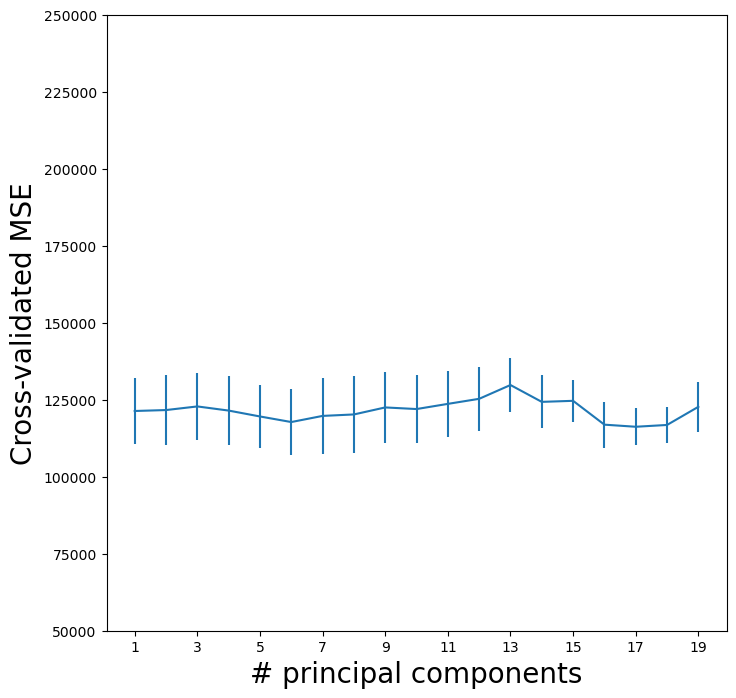

In [58]:
pcr_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([50000,250000]);

- The smallest cross-validation error occurs with 17 components, but the plot shows that the cross-validation error is similar when only one component is included. This suggests that a model with just a few components may be sufficient.
- The CV score is provided for each number of components from 1 to 19. The `PCA()` method does not allow fitting an intercept with `n_components=0`, so we also compute the MSE for the null model with these splits.

In [148]:
Xn = np.zeros((X.shape[0], 1))
cv_null = skm.cross_validate(linreg,
                             Xn,
                             Y,
                             cv=kfold,
                             scoring='neg_mean_squared_error')
-cv_null['test_score'].mean()

204139.30692994667

- The `explained_variance_ratio_` attribute of our `PCA` object shows the percentage of variance explained in the predictors and the response using different numbers of components. This concept is explored in more detail in the book.

In [149]:
pipe.named_steps['pca'].explained_variance_ratio_

array([0.3831424 , 0.21841076])

- In brief, we can interpret the explained variance as the amount of information about the predictors captured by \(M\) principal components.
- For example, with \(M=1\), we capture 38.31% of the variance, and with \(M=2\), we capture an additional 21.84%, totaling 60.15%. By \(M=6\), this increases to 88.63%.
- Beyond that, the increments diminish until we use all \(M=p=19\) components, which capture 100% of the variance.

# Partial Least Squares
- Partial least squares (PLS) is implemented in the `PLSRegression()`  function. 

In [59]:
pls = PLSRegression(n_components=2, 
                    scale=True)
pls.fit(X, Y)

PLSRegression()

- Similar to PCR, we will use cross-validation (CV) to determine the optimal number of components.

In [60]:
param_grid = {'n_components':range(1, 20)}
grid = skm.GridSearchCV(pls,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

- As with our other methods, we will plot the MSE.

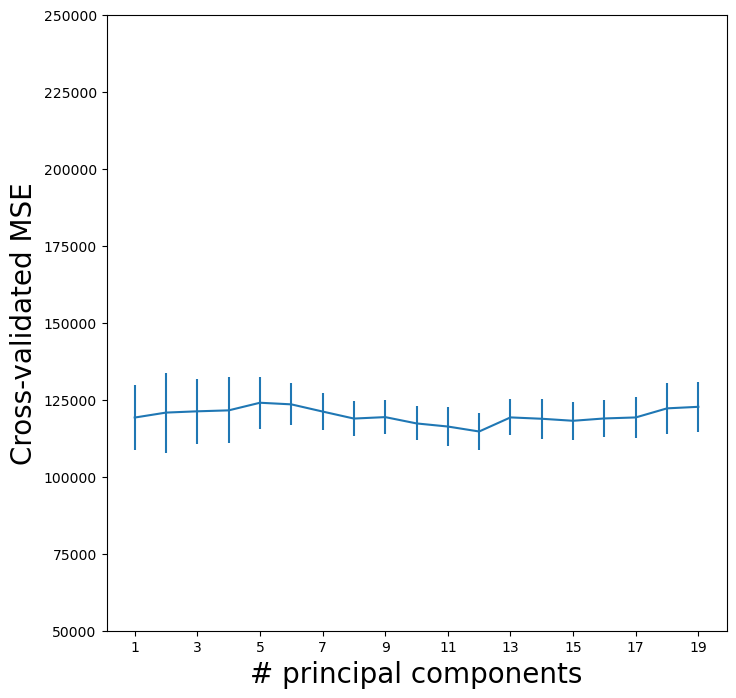

In [152]:
pls_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([50000,250000]);

- The CV error is minimized at 12 components, but there is only a small difference in performance compared to using just 2 or 3 components.